In [131]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

<Figure size 432x288 with 0 Axes>

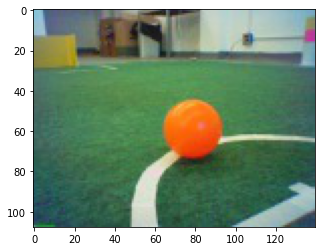

In [132]:
def imshow(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)

plt.set_cmap('gray')
img_1 = cv2.imread('Picture 1.jpg')
img_2 = cv2.imread('Picture 2.jpg')
img_3 = cv2.imread('Picture 3.jpg')
img_4 = cv2.imread('Picture 4.jpg')
image_set = [img_1, img_2, img_3, img_4]
imshow(image_set[0])

# Thresholding

IMG SHAPE:  (108, 140, 3)
RED: 132, GREEN: 139, BLUE: 88
RED: 253, GREEN: 85, BLUE: 172
RED: 255, GREEN: 62, BLUE: 146
RED: 4, GREEN: 156, BLUE: 195


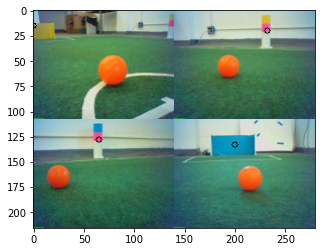

In [133]:
# Thresholding - sampling
imgs = image_set
print('IMG SHAPE: ', imgs[0].shape)
pts_ball = [(80, 60),(55, 55),(25, 55),(70, 60)]
pts = [(0, 15),(92, 20), (65, 20), (60, 25)]
samples = [imgs[i][pts[i][1], pts[i][0], :] for i in range(len(imgs))]
imgs_disp = [cv2.circle(imgs[i].copy(), pts[i], 3, (0, 0, 0)) for i in range(len(imgs))]

for sample in samples:
    print('RED: ' + str(sample[2]) + ', GREEN: ' + str(sample[1]) + ', BLUE: ' + str(sample[0]))

imshow(np.concatenate([
    np.concatenate([imgs_disp[0], imgs_disp[1]], axis=1),
    np.concatenate([imgs_disp[2], imgs_disp[3]], axis=1)
], axis=0))

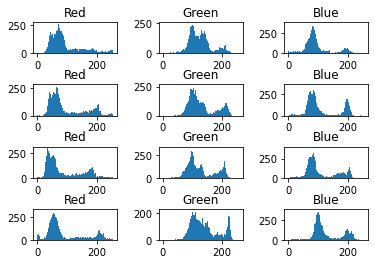

In [134]:
# Thresholding - Histograms
fig, axes = plt.subplots(4, 3)
plt.subplots_adjust(hspace=1, wspace=0.5)
channels = ["Red", "Green", "Blue"]
for i in range(4):
    for c in range(3):
        axes[i][c].hist(imgs[i][:,:, 2 - c].ravel(), 256, [0, 256])
        axes[i][c].set_title(channels[c])
plt.show()

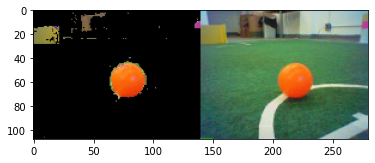

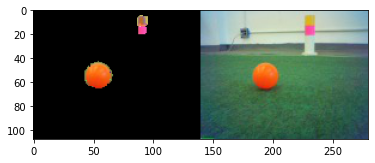

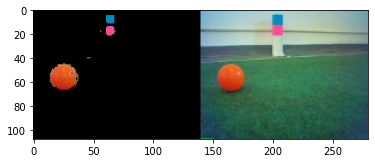

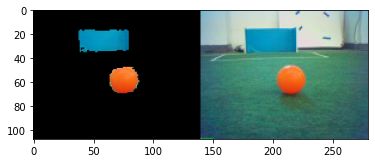

In [135]:
def threshold(img, lower, higher):
    th = np.zeros(img.shape, dtype=np.uint8)
    th[img  >= lower] = 1
    th[img  > higher] = 0
    return th

def rgb_threshold(img, r, g, b):
    th = threshold(img[:,:, 2], r[0], r[1])
    th *= threshold(img[:,:, 1], g[0], g[1])
    th *= threshold(img[:,:, 0], b[0], b[1])
    return np.repeat(th[:, :, np.newaxis], 3, axis=2)

ball = lambda img: rgb_threshold(img, (170, 256), (0, 200), (0, 120))  * img
yellow_g = lambda img: rgb_threshold(img, (100, 180), (40, 160), (40, 90)) * img
yellow_b = lambda img: rgb_threshold(img, (200, 256), (169, 200), (0, 90)) * img
blue= lambda img: rgb_threshold(img, (0,20), (100, 190), (0, 256)) * img
pink = lambda img: rgb_threshold(img, (100, 256), (0, 100), (100, 256)) * img

for i in range(len(imgs)):
    img_segment = yellow_b(imgs[i]) + yellow_g(imgs[i]) + ball(imgs[i]) + blue(imgs[i]) + pink(imgs[i])
    imshow(np.concatenate([img_segment, imgs[i]], axis=1))

# Region Growing

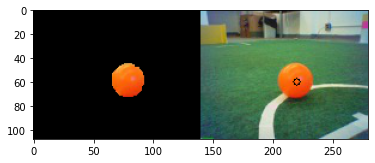

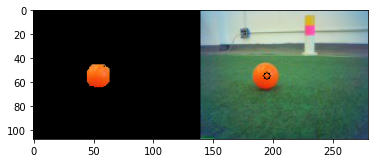

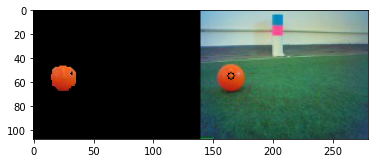

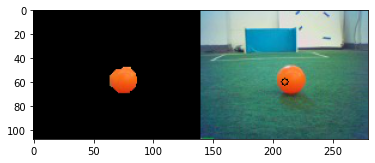

In [143]:
def neighbours(pt, img):
    h, w, c = img.shape
    pi, pj = pt
    ns = [(pi + i, pj + j) for i in range(-1,2) for j in range(-1,2) if not (i == 0 and j == 0)]
    return [n for n in ns if n[0] >= 0 and n[0] < h and n[1] >= 0 and n[1] < w]

def sad(pt1, pt2): # SAD
    return sum([abs(int(pt2[i]) - int(pt1[i])) for i in range(len(pt1))])

def select_mask(img, mask):
    rgb_mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2).astype(np.uint8)
    return img * rgb_mask

def grow_region(img, seed, th):
    seed_ij = (seed[1], seed[0])

    regions = np.zeros(img.shape[:2], dtype=np.uint8)
    to_visit = [seed_ij]
    regions[seed_ij] = 1

    while (len(to_visit) > 0):
        pt = to_visit.pop(0)
        ns = neighbours(pt, img)
        ns = [n for n in ns if regions[n] == 0]
        sim_ns = [n for n in ns if sad(img[pt], img[n]) < th]
        for p in sim_ns:
            regions[p] = 1
        to_visit += sim_ns
    return regions

pts = [(80, 60),(55, 55),(25, 55),(70, 60)]

for i in range(len(imgs)):
    mask = grow_region(imgs[i], pts[i], 35)
    disp_img = cv2.circle(imgs[i].copy(), pts[i], 3, (0, 0, 0))
    imshow(np.concatenate([select_mask(imgs[i], mask), disp_img], axis=1))

Number of Iterations:  24
Number of Iterations:  23
Number of Iterations:  26
Number of Iterations:  25


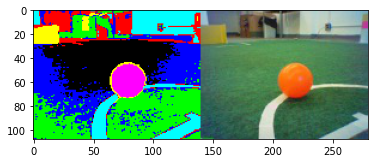

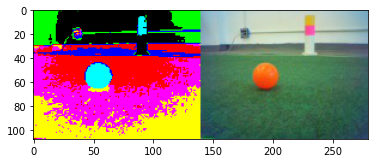

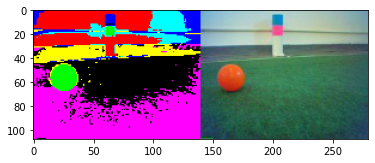

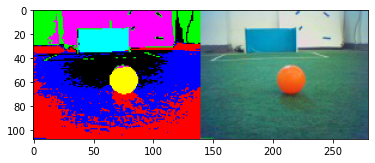

In [148]:
# K-nearest neighbour
import random

def sad(pt1, pt2):
    return sum([abs(float(pt2[i]) - float(pt1[i])) for i in range(len(pt1))])

def knn(img, n_clusters):
    h, w, c = img.shape

    # pick n random clusters
    centroids_i = random.sample(range(0, h), n_clusters)
    centroids_j = random.sample(range(0, w), n_clusters)
    centroids = np.array([centroids_i, centroids_j]).T.tolist()
    centroids = [img[tuple(c)] for c in centroids]

    for n_it in range(1000): # just in case

        clusters = [[] for c in range(len(centroids))]
        clusters_idx = [[] for c in range(len(centroids))]

        for i in range(h):
            for j in range(w):
                c_index = np.argmin([sad(c, img[(i,j)]) for c in centroids])
                clusters[c_index].append(img[(i, j)])
                clusters_idx[c_index].append((i, j))

        new_centroids = [np.mean(np.array(cluster), axis=0) for cluster in clusters]

        if sum([sad(centroids[i], new_centroids[i]) for i in range(len(centroids))]) == 0:
            break

        centroids = new_centroids

    return clusters_idx, n_it

def color_map(img, clusters, c_map):
    map = np.zeros(img.shape, dtype=np.uint8)
    for i in range(len(clusters)):
        for p in clusters[i]:
            map[p] = c_map[i]
    return map

c_map = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0], [255, 255, 255]])
n_clusters = 7
for i in range(len(imgs)):
    clusters, n_it = knn(imgs[i], n_clusters)
    imshow(np.concatenate([color_map(imgs[i], clusters, c_map), imgs[i]], axis=1))
    print('Number of Iterations: ', n_it)